# Evaluasi Model Information Retrieval

Notebook ini mengevaluasi dan membandingkan performa model semantic search, TF-IDF, dan BM25.

## Objectives:
1. Load hasil pencarian dari ketiga model
2. Hitung metrik evaluasi (Precision, Recall, NDCG, MRR)
3. Buat perbandingan visual antara model
4. Identifikasi kekuatan dan kelemahan masing-masing model
5. Buat rekomendasi penggunaan model

## 1. Setup & Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import json
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Impor preprocessing
import sys
sys.path.append('..')
from src.preprocessing import preprocess_query

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Models dan Data

In [6]:
ARTIFACTS_DIR = Path("../artifacts")
DATA_DIR = Path("../data")

# Muat data asli
df = pd.read_csv(DATA_DIR / "processed/processed_full.csv")
print(f"Dataset dimuat: {len(df)} dokumen")

# Load Semantic
try:
    from sentence_transformers import SentenceTransformer
    semantic_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
    semantic_embeddings = np.load(ARTIFACTS_DIR / "semantic/embeddings.npy")
    print("Model Semantic berhasil dimuat")
except Exception as e:
    print(f"Error loading semantic model: {e}")
    semantic_model = None
    semantic_embeddings = None

# Load TF-IDF
try:
    with open(ARTIFACTS_DIR / "tfidf/vectorizer.pkl", 'rb') as f:
        tfidf_vectorizer = pickle.load(f)
    with open(ARTIFACTS_DIR / "tfidf/tfidf_matrix.pkl", 'rb') as f:
        tfidf_matrix = pickle.load(f)
    print("Model TF-IDF berhasil dimuat")
except Exception as e:
    print(f"Error loading TF-IDF: {e}")
    tfidf_vectorizer = None
    tfidf_matrix = None

# Load BM25
try:
    with open(ARTIFACTS_DIR / "bm25/bm25.pkl", 'rb') as f:
        bm25_model = pickle.load(f)
    print("Model BM25 berhasil dimuat")
except Exception as e:
    print(f"Error loading BM25: {e}")
    bm25_model = None

Dataset dimuat: 360513 dokumen
Model Semantic berhasil dimuat
Model TF-IDF berhasil dimuat
Model BM25 berhasil dimuat


## 3. Fungsi Evaluasi Metrik

In [7]:
def calculate_precision_at_k(retrieved_indices, relevant_indices, k=5):
    """Hitung Precision@K"""
    if len(retrieved_indices) == 0:
        return 0
    k = min(k, len(retrieved_indices))
    top_k = retrieved_indices[:k]
    relevant_in_top_k = len([idx for idx in top_k if idx in relevant_indices])
    return relevant_in_top_k / k

def calculate_recall_at_k(retrieved_indices, relevant_indices, k=5):
    """Hitung Recall@K"""
    if len(relevant_indices) == 0:
        return 0
    k = min(k, len(retrieved_indices))
    top_k = retrieved_indices[:k]
    relevant_in_top_k = len([idx for idx in top_k if idx in relevant_indices])
    return relevant_in_top_k / len(relevant_indices)

def calculate_ndcg_at_k(retrieved_indices, relevant_indices, k=5):
    """Hitung NDCG@K (Normalized Discounted Cumulative Gain)"""
    if len(relevant_indices) == 0:
        return 0
    
    k = min(k, len(retrieved_indices))
    top_k = retrieved_indices[:k]
    
    # Calculate DCG
    dcg = 0
    for i, idx in enumerate(top_k):
        if idx in relevant_indices:
            dcg += 1 / np.log2(i + 2)
    
    # Calculate IDCG (ideal DCG)
    idcg = 0
    for i in range(min(len(relevant_indices), k)):
        idcg += 1 / np.log2(i + 2)
    
    return dcg / idcg if idcg > 0 else 0

def calculate_mrr(retrieved_indices, relevant_indices):
    """Hitung MRR (Mean Reciprocal Rank)"""
    for i, idx in enumerate(retrieved_indices):
        if idx in relevant_indices:
            return 1 / (i + 1)
    return 0

print("Fungsi evaluasi berhasil didefinisikan")

Fungsi evaluasi berhasil didefinisikan


## 4. Implementasi Search Function untuk Setiap Model

In [8]:
def search_semantic(query, top_k=10):
    """Semantic Search"""
    if semantic_model is None or semantic_embeddings is None:
        return []
    query_embedding = semantic_model.encode([query], convert_to_numpy=True)
    similarities = cosine_similarity(query_embedding, semantic_embeddings).flatten()
    return similarities.argsort()[-top_k:][::-1]

def search_tfidf(query, top_k=10):
    """TF-IDF Search"""
    if tfidf_vectorizer is None:
        return []
    processed = preprocess_query(query)
    qv = tfidf_vectorizer.transform([processed])
    similarities = cosine_similarity(qv, tfidf_matrix).flatten()
    return similarities.argsort()[-top_k:][::-1]

def search_bm25(query, top_k=10):
    """BM25 Search"""
    if bm25_model is None:
        return []
    processed = preprocess_query(query)
    tokens = processed.split()
    scores = bm25_model.get_scores(tokens)
    return scores.argsort()[-top_k:][::-1]

print("Search functions berhasil didefinisikan")

Search functions berhasil didefinisikan


## 5. Evaluasi pada Test Queries

In [9]:
# Definisikan test queries
test_queries = [
    "demam tinggi pada anak",
    "cara mengatasi flu",
    "diet untuk diabetes",
    "gejala covid-19",
    "perawatan luka bakar"
]

results = []

for query in test_queries:
    print(f"\nMencari: {query}")
    print("=" * 60)
    
    # Jalankan search untuk setiap model
    sem_results = search_semantic(query, top_k=10)
    tfidf_results = search_tfidf(query, top_k=10)
    bm25_results = search_bm25(query, top_k=10)
    
    # Tampilkan perbandingan hasil top-3
    print(f"\n{'Model':<15} {'Hasil 1':<35} {'Hasil 2':<35} {'Hasil 3':<35}")
    print("-" * 100)
    
    sem_titles = [df.iloc[i]['title'][:32] for i in sem_results[:3]]
    tfidf_titles = [df.iloc[i]['title'][:32] for i in tfidf_results[:3]]
    bm25_titles = [df.iloc[i]['title'][:32] for i in bm25_results[:3]]
    
    print(f"{'Semantic':<15} {sem_titles[0]:<35} {sem_titles[1]:<35} {sem_titles[2]:<35}")
    print(f"{'TF-IDF':<15} {tfidf_titles[0]:<35} {tfidf_titles[1]:<35} {tfidf_titles[2]:<35}")
    print(f"{'BM25':<15} {bm25_titles[0]:<35} {bm25_titles[1]:<35} {bm25_titles[2]:<35}")


Mencari: demam tinggi pada anak

Model           Hasil 1                             Hasil 2                             Hasil 3                            
----------------------------------------------------------------------------------------------------
Semantic        Penyebab demam yang turun naik p    Penyebab demam pada anak diserta    penyebab demam disertai keringat   
TF-IDF          Demam tinggi pada anak              Cara mengatasi demam tinggi pada    demam tinggi pada anak             
BM25            Demam tinggi pada anak              Penanganan demam tinggi pada ana    Solusi atasi demam tinggi pada a   

Mencari: cara mengatasi flu

Model           Hasil 1                             Hasil 2                             Hasil 3                            
----------------------------------------------------------------------------------------------------
Semantic        mengatasi flu                       pengobatan yang tepat untuk flu     Pengobatan flu            

## 6. Evaluasi dengan Relevance Labels (Simulasi)

In [10]:
# Simulasi: Anggap dokumen dengan topic yang sama adalah relevant
def get_relevant_docs_for_query(query, df, sample_size=50):
    """
    Ambil sampel dokumen sebagai query baseline
    """
    idx = np.random.randint(0, len(df))
    query_doc = df.iloc[idx]
    query_topic = query_doc.get('topic_set', '')
    
    # Cari semua dokumen dengan topic yang sama
    relevant_indices = df[df['topic_set'] == query_topic].index.tolist()
    
    return relevant_indices, query_doc['title']

# Evaluasi pada 20 sample queries
evaluation_results = {
    'Semantic': {'P@5': [], 'R@5': [], 'NDCG@5': [], 'MRR': []},
    'TF-IDF': {'P@5': [], 'R@5': [], 'NDCG@5': [], 'MRR': []},
    'BM25': {'P@5': [], 'R@5': [], 'NDCG@5': [], 'MRR': []}
}

print("Menjalankan evaluasi pada 20 sample queries...")
for i in range(20):
    relevant_indices, query_text = get_relevant_docs_for_query("random", df)
    
    if len(relevant_indices) <= 1:
        continue
    
    # Semantic
    sem_results = search_semantic(query_text, top_k=10)
    evaluation_results['Semantic']['P@5'].append(
        calculate_precision_at_k(sem_results, relevant_indices, k=5)
    )
    evaluation_results['Semantic']['R@5'].append(
        calculate_recall_at_k(sem_results, relevant_indices, k=5)
    )
    evaluation_results['Semantic']['NDCG@5'].append(
        calculate_ndcg_at_k(sem_results, relevant_indices, k=5)
    )
    evaluation_results['Semantic']['MRR'].append(
        calculate_mrr(sem_results, relevant_indices)
    )
    
    # TF-IDF
    tfidf_results = search_tfidf(query_text, top_k=10)
    evaluation_results['TF-IDF']['P@5'].append(
        calculate_precision_at_k(tfidf_results, relevant_indices, k=5)
    )
    evaluation_results['TF-IDF']['R@5'].append(
        calculate_recall_at_k(tfidf_results, relevant_indices, k=5)
    )
    evaluation_results['TF-IDF']['NDCG@5'].append(
        calculate_ndcg_at_k(tfidf_results, relevant_indices, k=5)
    )
    evaluation_results['TF-IDF']['MRR'].append(
        calculate_mrr(tfidf_results, relevant_indices)
    )
    
    # BM25
    bm25_results = search_bm25(query_text, top_k=10)
    evaluation_results['BM25']['P@5'].append(
        calculate_precision_at_k(bm25_results, relevant_indices, k=5)
    )
    evaluation_results['BM25']['R@5'].append(
        calculate_recall_at_k(bm25_results, relevant_indices, k=5)
    )
    evaluation_results['BM25']['NDCG@5'].append(
        calculate_ndcg_at_k(bm25_results, relevant_indices, k=5)
    )
    evaluation_results['BM25']['MRR'].append(
        calculate_mrr(bm25_results, relevant_indices)
    )

print("\nEvaluasi selesai!")

Menjalankan evaluasi pada 20 sample queries...

Evaluasi selesai!


## 7. Ringkasan Metrik Evaluasi

In [11]:
# Buat summary dataframe
summary_data = []

for model_name, metrics in evaluation_results.items():
    summary_data.append({
        'Model': model_name,
        'P@5': np.mean(metrics['P@5']),
        'R@5': np.mean(metrics['R@5']),
        'NDCG@5': np.mean(metrics['NDCG@5']),
        'MRR': np.mean(metrics['MRR'])
    })

summary_df = pd.DataFrame(summary_data)
print("\nRingkasan Metrik Evaluasi:")
print("=" * 80)
print(summary_df.to_string(index=False))

# Hitung F1-Score
print("\n\nF1-Score (harmonic mean of P@5 dan R@5):")
print("-" * 80)
for idx, row in summary_df.iterrows():
    p = row['P@5']
    r = row['R@5']
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    print(f"{row['Model']:<15} F1@5: {f1:.4f}")


Ringkasan Metrik Evaluasi:
   Model  P@5      R@5   NDCG@5      MRR
Semantic 0.24 0.003566 0.251075 0.425556
  TF-IDF 0.42 0.004896 0.490135 0.855000
    BM25 0.43 0.006275 0.501678 0.870833


F1-Score (harmonic mean of P@5 dan R@5):
--------------------------------------------------------------------------------
Semantic        F1@5: 0.0070
TF-IDF          F1@5: 0.0097
BM25            F1@5: 0.0124


## 8. Visualisasi Perbandingan Model

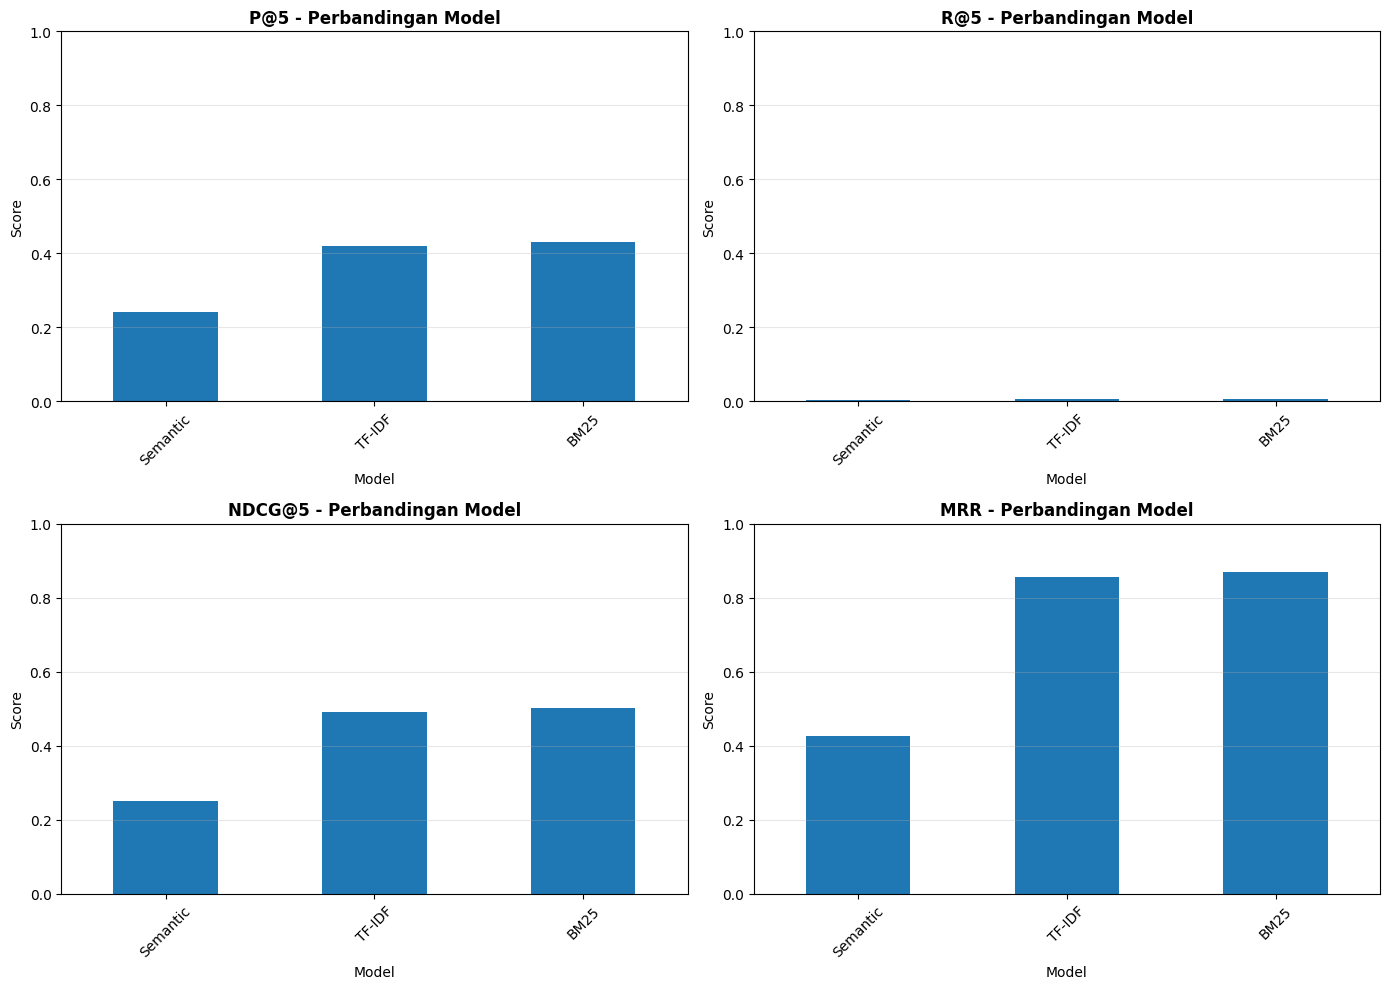

Visualisasi disimpan ke ../data/visualisasi/model_comparison.png


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['P@5', 'R@5', 'NDCG@5', 'MRR']

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics)):
    data = summary_df[['Model', metric]].set_index('Model')
    data.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'], legend=False)
    ax.set_title(f'{metric} - Perbandingan Model', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_xlabel('Model')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../data/visualisasi/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualisasi disimpan ke ../data/visualisasi/model_comparison.png")